<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/GeneticOptimization_for_StructuralDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic Optimization for Structural Truss Design

This project implements a genetic algorithm to optimize the design of a truss structure. The code aims to find the best configuration of nodes (points) that minimizes the displacement and material usage under specific loads and constraints. The optimization is achieved through evolutionary techniques such as crossover and mutation.

## Main Code Components

### 1. **Delaunay Triangulation**
   - The truss structure is generated using Delaunay triangulation, which connects a set of points to form a network of edges. This ensures that the truss design is efficient and avoids overly long or short beams that would violate physical constraints.

### 2. **Finite Element Analysis (FEM)**
   - FEM is used to calculate the displacement of the truss under applied forces. The stiffness matrix of the structure is built, and boundary conditions are applied to solve for the displacement vector.

### 3. **Fitness Calculation**
   - The fitness function evaluates the quality of each truss configuration. It considers two main factors:
     - **Displacement Penalty**: The total deformation of the structure under load.
     - **Material Penalty**: The total length of all beams in the truss, which relates to material usage.

### 4. **Genetic Algorithm**
   - The optimization process involves the evolution of a population of truss configurations over several generations. Key operations include:
     - **Crossover**: Combining two parent solutions to create a new child solution.
     - **Mutation**: Introducing random changes to the child solutions to explore the solution space.
   - The algorithm selects the best-performing configurations and iteratively improves them until a stopping criterion is met.

---
  
## Genetic Optimization Overview

### What is Genetic Optimization?
Genetic optimization is a type of evolutionary algorithm inspired by the principles of natural selection and genetics. It is used to solve complex optimization problems where traditional methods may struggle due to the vast search space or the presence of multiple local optima. The process involves:
- **Selection**: Choosing the best-performing individuals from a population based on their fitness.
- **Crossover (Recombination)**: Combining parts of two parent solutions to create offspring that inherit characteristics from both.
- **Mutation**: Introducing random changes to offspring to maintain genetic diversity and explore new regions of the solution space.
- **Survival of the Fittest**: Replacing less fit individuals in the population with more fit offspring to continually improve the overall population.

### Application to Truss Design
In this project, genetic optimization is applied to the problem of designing a truss structure, which is a framework of connected beams that can support loads. The algorithm seeks to find the best arrangement of nodes (points) that minimizes:
- **Displacement**: The extent to which the structure deforms under load.
- **Material Usage**: The total length of beams, representing the cost and weight of the structure.

### Key Components of the Genetic Algorithm

#### 1. **Population Initialization**
   - A population of possible truss configurations is generated. Each configuration consists of a set of points representing the nodes of the truss.
   - To maintain feasibility, fixed points (nodes that must remain stationary) are not altered during the initialization or evolution processes.

#### 2. **Fitness Evaluation**
   - **Fitness Function**: The fitness of each individual truss is evaluated based on two criteria:
     - **Displacement Penalty**: Calculated using Finite Element Analysis (FEM) to determine how much the structure deforms under applied forces.
     - **Material Penalty**: Calculated as the total length of all the beams, encouraging designs that use less material.
   - The overall fitness is a weighted sum of these penalties, where lower values indicate better designs.

#### 3. **Selection**
   - Individuals with higher fitness (lower fitness scores) are more likely to be selected as parents for the next generation. Selection methods such as roulette wheel selection or tournament selection can be used.

#### 4. **Crossover (Recombination)**
   - Pairs of parent configurations are selected, and their node positions are combined to produce offspring. This process mimics biological reproduction, where the offspring inherit features from both parents.

#### 5. **Mutation**
   - To maintain diversity in the population and avoid premature convergence to local optima, mutations are introduced. Random changes are made to the positions of some nodes, except for fixed points, with a certain probability.

#### 6. **Survival and Replacement**
   - After generating a new population through crossover and mutation, the algorithm selects the best individuals from both the old and new populations to form the next generation.
   - This process is repeated for a predefined number of generations or until no significant improvement is observed (measured by the **patience** parameter).

### Termination and Results
- The algorithm terminates when a maximum number of generations is reached, or when no improvement is observed over a certain number of generations (controlled by the `PATIENCE` parameter).
- The best-performing truss configuration is selected as the final solution.
- The evolution of the truss design over generations can be visualized, and a GIF can be created to display the optimization process.

## Usage Example

To use the code, simply define an initial set of points, specify the forces acting on these points, and identify any fixed points. The genetic algorithm will evolve the truss design over a specified number of generations.

```python
# Example usage
initial_points = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
forces = np.array([[0, 0], [0, 0], [0.5, -0.6], [0.3, 0.2]])
fixed_points = [0, 1]

pop_size = 50
n_gens = 100

best_points = genetic_algorithm(num_generations=n_gens, population_size=pop_size, points=initial_points, forces=forces, fixed_points=fixed_points, E=1, patience=PATIENCE)
create_gif(num_generations=n_gens)  
```
---

##**Core Dependencies**
numpy: 1.26.4  
matplotlib: 3.7.1  
IPython: 7.34.0  
imageio: 2.34.2  
scipy: 1.13.1  


In [ ]:
# @title Imports

from typing import List

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import random
import imageio.v2 as imageio
import os
from IPython.display import display, Image
# Set the seed for reproducibility
def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)

set_seed(89)



#_______________________________________________________________________________
# CHECK PACKAGES VERSION:
#_______________________________________________________________________________
#! pip list
#import os
#packages = [
#    'numpy',
#    'matplotlib',
#    'IPython',
#    'imageio'
#    'scipy',
#
#]
#
#for package in packages:
#    try:
#        version = os.popen(f"pip show {package} | grep Version").read().strip().split(': ')[1]
#        print(f"{package}: {version}")
#    except Exception as e:
#        print(f"Error getting version for {package}: {e}")
#
#_______________________________________________________________________________
# THE FOLLOWING CODE WORKS PROPERLY WITH THESE PACKAGES VERSION:
#_______________________________________________________________________________
#numpy: 1.26.4
#matplotlib: 3.7.1
#IPython: 7.34.0
#imageio: 2.34.2
#scipy: 1.13.1
#_______________________________________________________________________________

In [2]:
# @title Core Code

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# Optimization Parameters

# Beam Length limits
MIN_LENGTH = 0.5
MAX_LENGTH = 2.0

# Patience parameter, max iteration with no improvements
PATIENCE = 15
MUTATION_RATE = 0.15

#-------------------------------------------------------------------------------
# Plotting parameters

DEFORM_SCALE = 0.1
SHOW_TRACE   = 1

#-------------------------------------------------------------------------------

def generate_truss(points):
    tri = Delaunay(points)
    edges = set()
    for simplex in tri.simplices:
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            xi, yi = points[edge[0]]
            xj, yj = points[edge[1]]
            length = np.sqrt((xj - xi) ** 2 + (yj - yi) ** 2)
            if MIN_LENGTH <= length <= MAX_LENGTH:
                edges.add(edge)
            else:
                print(f"Warning: Edge {edge} with length {length:.2f} is out of bounds. Length should be between {MIN_LENGTH} and {MAX_LENGTH}.")
    return list(edges)

def fem_analysis(points, edges, forces, fixed_points, E=1.0):
    num_points = len(points)
    num_dofs = 2 * num_points
    stiffness_matrix = np.zeros((num_dofs, num_dofs))
    force_vector = forces.flatten()

    # Build stiffness matrix
    for edge in edges:
        i, j = edge
        xi, yi = points[i]
        xj, yj = points[j]
        length = np.sqrt((xj - xi) ** 2 + (yj - yi) ** 2)
        c = (xj - xi) / length
        s = (yj - yi) / length
        k_local = E * np.array([[c * c, c * s, -c * c, -c * s],
                                [c * s, s * s, -c * s, -s * s],
                                [-c * c, -c * s, c * c, c * s],
                                [-c * s, -s * s, c * s, s * s]])
        k_global_indices = np.array([2 * i, 2 * i + 1, 2 * j, 2 * j + 1])
        for ii in range(4):
            for jj in range(4):
                stiffness_matrix[k_global_indices[ii], k_global_indices[jj]] += k_local[ii, jj]

    # Apply boundary conditions
    try:
        stiffness_matrix, force_vector, free_dofs = apply_boundary_conditions(stiffness_matrix, force_vector, fixed_points)
        displacement = np.linalg.solve(stiffness_matrix, force_vector)
    except np.linalg.LinAlgError:
        print("Generation: Singular matrix encountered, skipping...")
        return None

    # Re-add fixed point's displacement as zeros
    displacement_full = np.zeros(num_dofs)
    displacement_full[free_dofs] = displacement

    return displacement_full

def apply_boundary_conditions(stiffness_matrix, force_vector, fixed_points):
    fixed_dofs = []
    for p in fixed_points:
        fixed_dofs.extend([2 * p, 2 * p + 1])

    free_dofs = np.setdiff1d(np.arange(stiffness_matrix.shape[0]), fixed_dofs)
    stiffness_matrix_free = stiffness_matrix[np.ix_(free_dofs, free_dofs)]
    force_vector_free = force_vector[free_dofs]

    return stiffness_matrix_free, force_vector_free, free_dofs

def fitness(points, edges, forces, fixed_points, E=1.0):
    displacement = fem_analysis(points, edges, forces, fixed_points, E)
    if displacement is None:
        return float('inf'), float('inf'), float('inf')  # High fitness value to skip this solution

    displacement_penalty = np.linalg.norm(displacement)

    total_length = sum(np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2) for i, j in edges)
    material_penalty = total_length

    total_fitness = displacement_penalty**2 + material_penalty #################### Fitness Score Calculation
    return total_fitness, displacement_penalty, material_penalty

def crossover(parent1, parent2, fixed_points):
    child = np.copy(parent1)
    for i in range(len(parent1)):
        if i not in fixed_points:
            child[i] = (parent1[i] + parent2[i]) / 2
    return child

def mutate(points, fixed_points, mutation_rate=MUTATION_RATE):
    mutated_points = np.copy(points)
    for i in range(len(mutated_points)):
        if i not in fixed_points:
            if random.random() < mutation_rate:
                mutated_points[i] += mutation_rate * np.random.randn(2)
    return mutated_points

def save_truss_plot(points, edges, forces, generation, history=None, displacements=None, xlim=None, ylim=None, scale=DEFORM_SCALE):
    plt.figure(figsize=(8, 8))

    # Plot the original truss members
    for edge in edges:
        i, j = edge
        x = [points[i][0], points[j][0]]
        y = [points[i][1], points[j][1]]
        plt.plot(x, y, 'bo-', lw=2, label='Original Truss' if displacements is None else '_nolegend_')

    # Plot the displaced truss members if displacements are provided
    if displacements is not None:
        for edge in edges:
            i, j = edge
            x = [points[i][0] + scale * displacements[2*i], points[j][0] + scale * displacements[2*j]]
            y = [points[i][1] + scale * displacements[2*i+1], points[j][1] + scale * displacements[2*j+1]]
            plt.plot(x, y, 'r--', lw=1, label='Displaced Truss' if i == 0 and j == 1 else '_nolegend_')

    # Plot the forces as arrows
    for i, (fx, fy) in enumerate(forces):
        plt.arrow(points[i][0], points[i][1], 0.1 * fx, 0.1 * fy, head_width=0.05, head_length=0.1, fc='green', ec='green', label='Forces' if i == 0 else '_nolegend_')

    # Plot the history of points
    if history is not None:
        for gen in range(len(history)):
            pts = history[gen]
            plt.scatter(pts[:, 0], pts[:, 1], alpha=SHOW_TRACE, color='grey', s=10, label='_nolegend_')

    plt.legend()
    plt.axis('equal')
    if xlim and ylim:
        plt.xlim(xlim)
        plt.ylim(ylim)
    plt.title(f'Generation {generation}')
    plt.savefig(f'generation_{generation}.png')
    plt.close()

def genetic_algorithm(num_generations, population_size, points, forces, fixed_points, E=1.0, patience=PATIENCE):
    all_points = [np.copy(points) + 0.1 * np.random.randn(*points.shape) for _ in range(population_size)]

    # Ensure fixed points are not modified in the initial population
    for i in fixed_points:
        for individual in all_points:
            individual[i] = points[i]

    x_min, y_min = np.min([np.min(individual, axis=0) for individual in all_points], axis=0)
    x_max, y_max = np.max([np.max(individual, axis=0) for individual in all_points], axis=0)

    xlim = (x_min - 0.5, x_max + 0.5)
    ylim = (y_min - 0.5, y_max + 0.5)

    initial_positions = np.copy(points)
    population = all_points
    initial_fitness = None
    best_fitness = float('inf')
    no_improvement_count = 0

    # Store history of points for tracking
    history = []

    for generation in range(num_generations):
        population_fitness = []
        for individual in population:
            edges = generate_truss(individual)
            if not edges:
                continue  # Skip if no valid edges are found
            total_fitness, displacement_penalty, material_penalty = fitness(individual, edges, forces, fixed_points, E)
            population_fitness.append((total_fitness, displacement_penalty, material_penalty, individual))

        if not population_fitness:
            print(f"Generation {generation}: No valid truss configurations found, skipping...")
            continue

        population_fitness.sort(key=lambda x: x[0])

        if initial_fitness is None:
            initial_fitness = population_fitness[0][0]

        normalized_fitness      = [f[0] / initial_fitness for f in population_fitness]
        normalized_displacement = [f[1] / initial_fitness for f in population_fitness]
        normalized_material     = [f[2] / initial_fitness for f in population_fitness]

        best_fitness_this_gen   = population_fitness[0][0]
        normalized_best_fitness = best_fitness_this_gen / initial_fitness

        if normalized_best_fitness < best_fitness:
            best_fitness = normalized_best_fitness
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        best_individual   = population_fitness[0][3]
        best_edges        = generate_truss(best_individual)
        best_displacement = fem_analysis(best_individual, best_edges, forces, fixed_points, E)

        # Save the history of points
        history.append(np.copy(best_individual))

        if best_displacement is not None:
            save_truss_plot(best_individual, best_edges, forces, generation, history=history, displacements=best_displacement, xlim=xlim, ylim=ylim, scale=DEFORM_SCALE)

        print(f"Generation {generation}: Best Fitness = {normalized_best_fitness:.2f}, "
              f"Displacement Fitness = {normalized_displacement[0]:.2f}, "
              f"Material Usage Fitness = {normalized_material[0]:.2f}, "
              f"Points = {best_individual.tolist()}")

        if no_improvement_count >= patience:
            print(f"Generation {generation}: No improvement after {patience} generations, stopping...")
            break

        selected_population = [individual for _, _, _, individual in population_fitness[:population_size // 2]]

        new_population = []
        while len(new_population) < population_size:
            parents = random.sample(selected_population, 2)
            child = crossover(parents[0], parents[1], fixed_points)
            child = mutate(child, fixed_points)
            # Ensure fixed points in the child remain fixed
            for i in fixed_points:
                child[i] = points[i]
            new_population.append(child)

        population = new_population

    return best_individual

def create_gif(num_generations):
    images = []
    for generation in range(num_generations):
        filename = f'generation_{generation}.png'
        if os.path.exists(filename):
            images.append(imageio.imread(filename))
    if images:
        imageio.mimsave('optimization_process.gif', images, duration=0.9, loop=0)


In [3]:
# @title Example Usage

!rm -rf generation_*

# points must be at least 3, feel free to add points
initial_points = np.array([[0, 0], [1, 0], [0, 1],      [1, 1]])
forces         = np.array([[0, 0], [0, 0], [0.5, -0.6], [0.3, 0.2]]) # be sure that forces numb is equal to points numb
fixed_points   = [0, 1] #The structure can't be free or in a singular config.

pop_size = 50
n_gens   = 100

best_points = genetic_algorithm(num_generations=n_gens, population_size=pop_size, points=initial_points, forces=forces, fixed_points=fixed_points, E=1, patience=PATIENCE)
create_gif(num_generations=n_gens)


Generation 0: Best Fitness = 1.00, Displacement Fitness = 0.22, Material Usage Fitness = 0.54, Points = [[0.0, 0.0], [1.0, 0.0], [0.1300196827864862, 0.7971986278273442], [1.1692345755416356, 1.0127088929256194]]
Generation 1: Best Fitness = 1.09, Displacement Fitness = 0.24, Material Usage Fitness = 0.54, Points = [[0.0, 0.0], [1.0, 0.0], [0.12401531796773177, 0.8655627635312779], [1.1194809885535548, 0.9926548138355686]]
Generation 2: Best Fitness = 1.11, Displacement Fitness = 0.25, Material Usage Fitness = 0.54, Points = [[0.0, 0.0], [1.0, 0.0], [0.055810763649771666, 0.8356332789114252], [0.970594319248494, 1.0816043615290551]]
Generation 3: Best Fitness = 0.93, Displacement Fitness = 0.20, Material Usage Fitness = 0.55, Points = [[0.0, 0.0], [1.0, 0.0], [-0.11615225677733773, 0.6518729838205821], [1.0718404778851152, 1.027266925106276]]
Generation 4: Best Fitness = 0.86, Displacement Fitness = 0.18, Material Usage Fitness = 0.56, Points = [[0.0, 0.0], [1.0, 0.0], [-0.063270762175

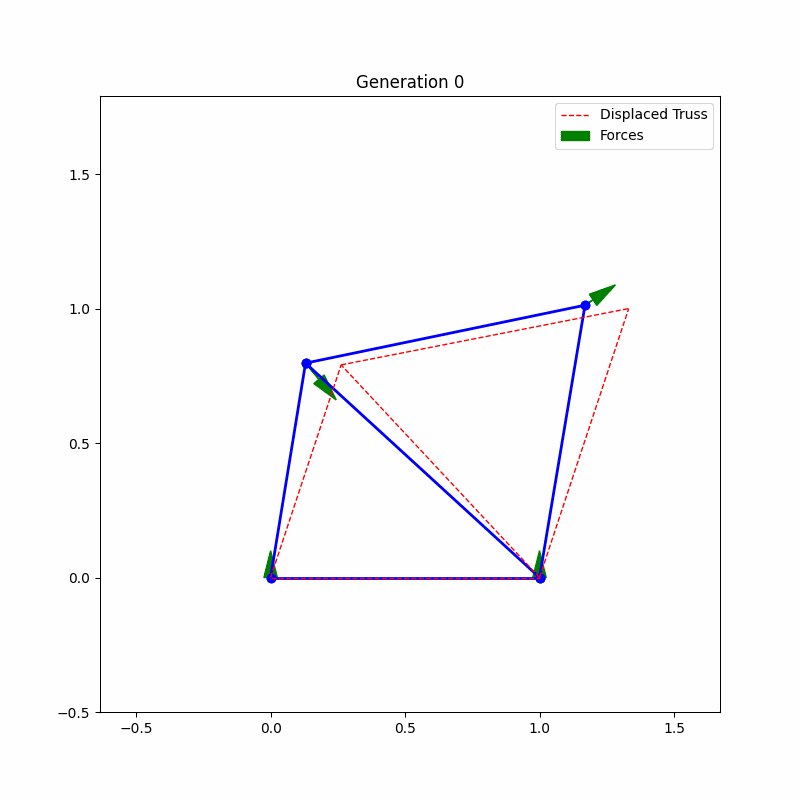

In [4]:
# @title Plot Optimization Process

gif_path = 'optimization_process.gif'
display(Image(filename=gif_path))